In [ ]:
######### libraries  ###########
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import json
from datetime import datetime
import random
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.formula.api import ols
### Visulaization libraries ########
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset

####Seasonality ###########

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

############## models #############
import math
from pandas import concat
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import Holt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

########## Evaluation library ##############
#from sklearn.metrics import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,median_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
# import warnings filter
from warnings import simplefilter

# ######### ignore all future warnings ########
simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter('ignore', ConvergenceWarning)
import warnings
warnings.filterwarnings('ignore')

C:\Users\fatima-zohra\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df=pd.read_csv('test_pred.csv')
df['DATE']= pd.to_datetime(df['DATE'])
df2=df.copy()
df2=df2.set_index('DATE')
df2

,exogVar,target_var
DATE,,
2015-04-01,0,1.193776e+09
2015-05-01,0,5.633517e+08
2015-06-01,0,4.864617e+08
2015-07-01,0,8.693845e+07
2015-08-01,0,4.241029e+08
...,...,...
2024-11-01,0,8.054504e+06
2024-12-01,0,2.102569e+07
2025-01-01,0,6.755353e+06


In [ ]:
data.isnull().sum()

date           0
exogVar        0
data_target    0
dtype: int64

In [ ]:
#======================== Stationnarity ==============================#
#============== Test Dickey-Fuller ==============#
#test dicky-fuller :  H0 =>  stationnaire
# function return the p-value
def adf_test(df):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df.target_var, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )
    return(dfoutput[1])
#============== Transformations pour rendre la serie stationnaire ==============#
def shift_transformation(df,targetVar):
    df_shift = df[targetVar] - df[targetVar]. shift ()
    return(df_shift.to_frame().dropna())
#=================================================
def log_transformation(df,targetVar):
    log_var = pd.DataFrame(df[targetVar].apply(lambda x : np.log(x)))
    arr=log_var[targetVar]
    arr[np.isneginf(arr)] = 0
    log_var[targetVar]=arr
    return(log_var.dropna())
#=================================================
def log_shift_transformation(df,targetVar):
    log_var = pd.DataFrame(df[targetVar].apply(lambda x : np.log(x)))
    arr=log_var[targetVar]
    arr[np.isneginf(arr)] = 0
    log_var[targetVar]=arr
    log_diff = log_var - log_var.shift()
    return(log_diff.dropna())
#=================================================
def power_transformation(df,targetVar):
    powered_transform = df[targetVar].apply(lambda x : x ** 0.5)
    return(powered_transform.to_frame().dropna())
#=================================================
def power_shift_transformation(df,targetVar):
    powered_transform = df[targetVar].apply(lambda x : x ** 0.5)
    powered_transform_diff = powered_transform - powered_transform.shift()
    return(powered_transform_diff.to_frame().dropna())
#=================================================
def Rolling_Mean_transformation(df,targetVar):
    rolling_mean= df[targetVar]. rolling ( window= 12 ) . mean ()
    return(rolling_mean.to_frame().dropna())
#=================================================
def Rolling_Mean_diff_transformation(df,targetVar):
    rolling_mean=df[targetVar].rolling ( window= 12 ).mean ()
    rolling_mean_diff= df[targetVar]-rolling_mean.shift()
    return(rolling_mean_diff.to_frame().dropna())
#============== Get The best transformation ==============#
def get_best_transformation(df, targetVar):
    transformations = [
        ("No transformation", lambda df, targetVar: df),
        ("shift_transformation", shift_transformation),
        ("log_transformation", log_transformation),
        ("log_shift_transformation", log_shift_transformation),
        ("power_transformation", power_transformation),
        ("power_shift_transformation", power_shift_transformation),
        ("Rolling_Mean_transformation", Rolling_Mean_transformation),
        ("Rolling_Mean_diff_transformation", Rolling_Mean_diff_transformation)
    ]

    sets = []
    p_values = []

    # Apply each transformation and calculate the ADF test p-value
    for name, func in transformations:
        transformed_df = func(df, targetVar)
        sets.append(transformed_df)
        p_values.append(adf_test(transformed_df))

    # Filter p-values less than or equal to 0.05
    valid_transformations = [(i, p) for i, p in enumerate(p_values) if p <= 0.05]

    if valid_transformations:
        # Get the best transformation (first one with p <= 0.05)
        best_index, best_p_value = valid_transformations[0]
    else:
        # Default to no transformation if none meet the p-value condition
        best_index, best_p_value = 0, p_values[0]

    # Retrieve the best transformed data
    best_data = sets[best_index]
    di = 1 if "shift" in transformations[best_index][0] else 0

    print(f"{transformations[best_index][0]} was applied.")

    # Handle exogenous variable and the difference-transformed data
    #best_data[exogVar] = df[exogVar]
    dff = sets[best_index - 1] if di == 1 else best_data
    #dff[exogVar] = df[exogVar]

    return best_data, best_p_value, best_index, dff, di


In [ ]:
best_data, best_p_value, best_index, dff, di=get_best_transformation(df2, "target_var")

Results of Dickey-Fuller Test:
Test Statistic                  -2.238288
p-value                          0.192644
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.143321e+00
p-value                        1.014357e-12
#Lags Used                     1.000000e+01
Number of Observations Used    1.080000e+02
Critical Value (1%)           -3.492401e+00
Critical Value (5%)           -2.888697e+00
Critical Value (10%)          -2.581255e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   1.001038
p-value                          0.994277
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)   

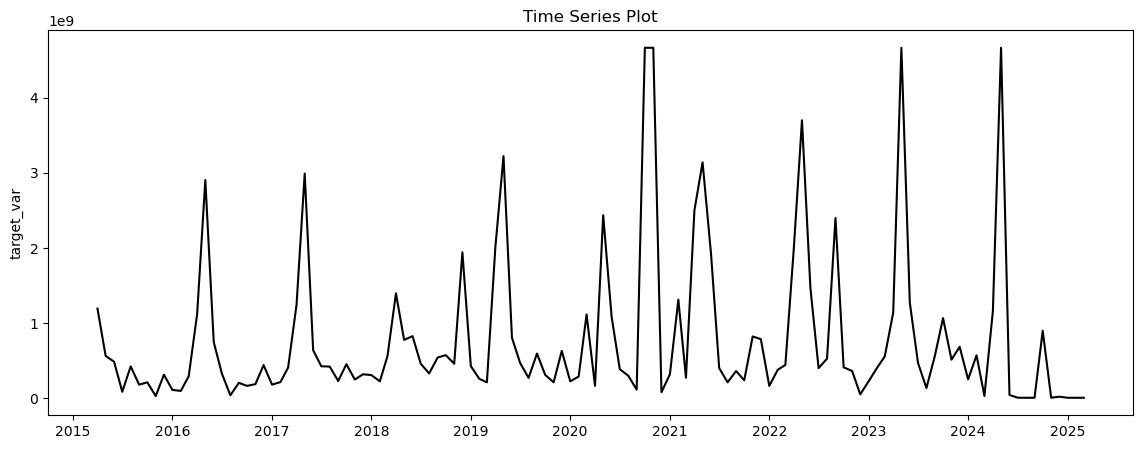

In [ ]:
# Plotting the time series
plt.figure(figsize=(14, 5))
plt.plot(df2.index, df2['target_var'], color='black')  # Assuming the column name for values is 'Value'
plt.ylabel('target_var')
plt.title('Time Series Plot')
plt.show()

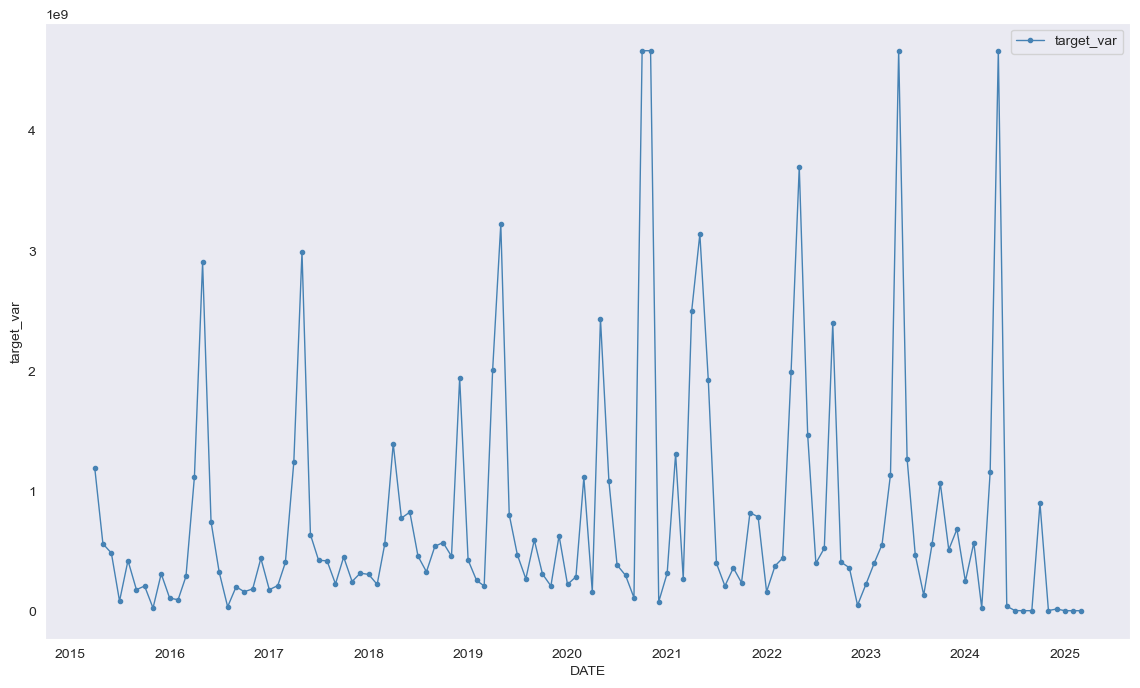

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style to match the uploaded graph
sns.set_style("dark")

# Plotting the data
plt.figure(figsize=(14, 8))
plt.plot(df['DATE'], df['target_var'], marker='o', color='steelblue', linewidth=1, markersize=3, label='target_var')
plt.xlabel('DATE')
plt.ylabel('target_var')
plt.legend()

plt.show()


<Figure size 1600x800 with 0 Axes>

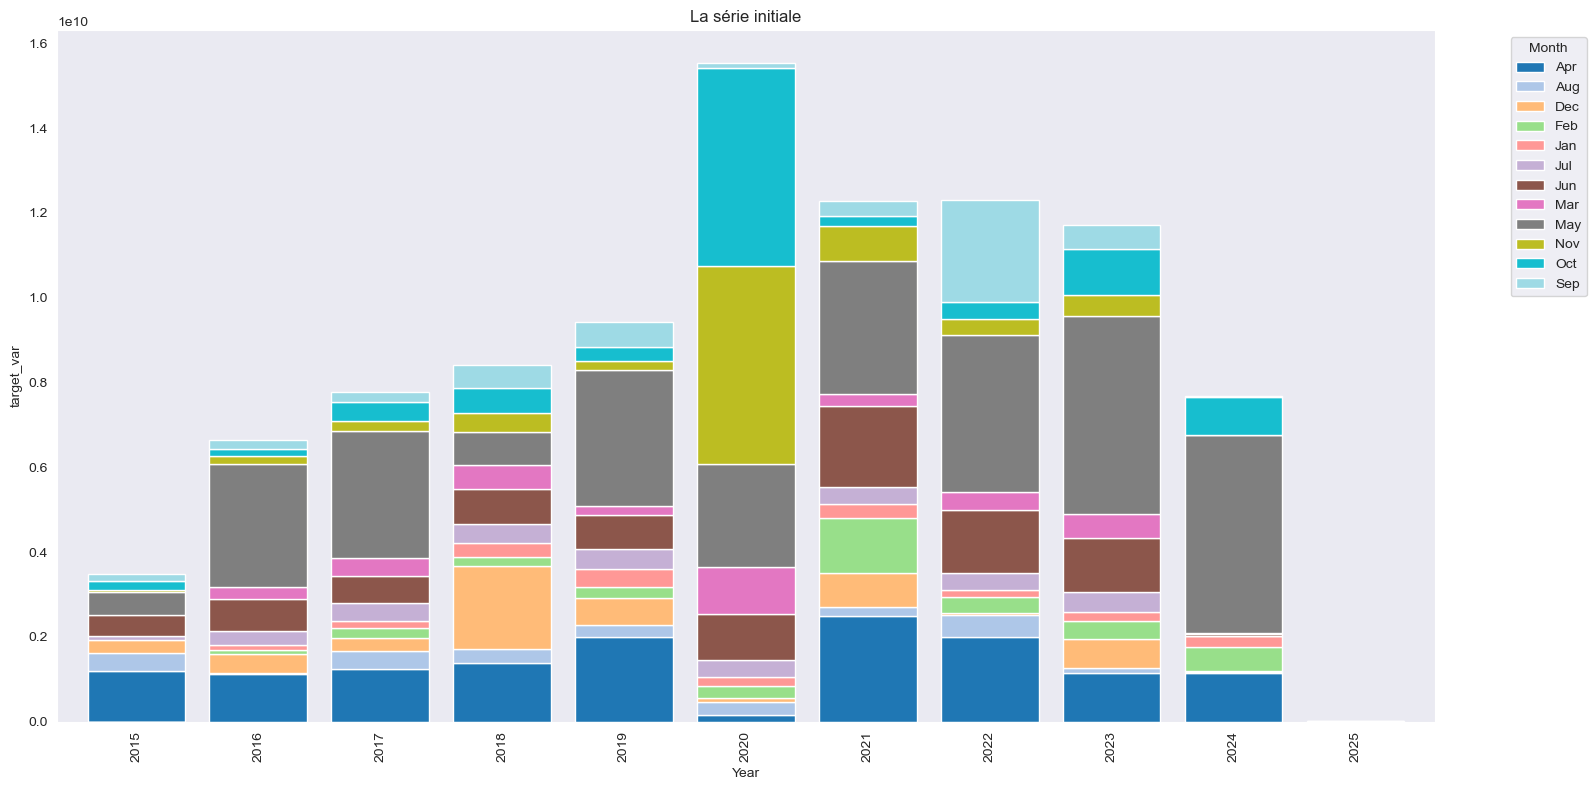

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
#data = pd.read_csv('/content/UNRATE.csv', parse_dates=['DATE'])
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.strftime('%b')  # Get month names

# Aggregate data by Year and Month for plotting
pivot_data = df.pivot_table(index='Year', columns='Month', values='target_var', aggfunc='mean')

# Set up plot style and size
sns.set_style("dark")
plt.figure(figsize=(16, 8))

# Plot
pivot_data.plot(kind='bar', stacked=True, width=0.8, colormap='tab20', figsize=(16, 8))
plt.title('La série initiale')
plt.xlabel('Year')
plt.ylabel('target_var')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


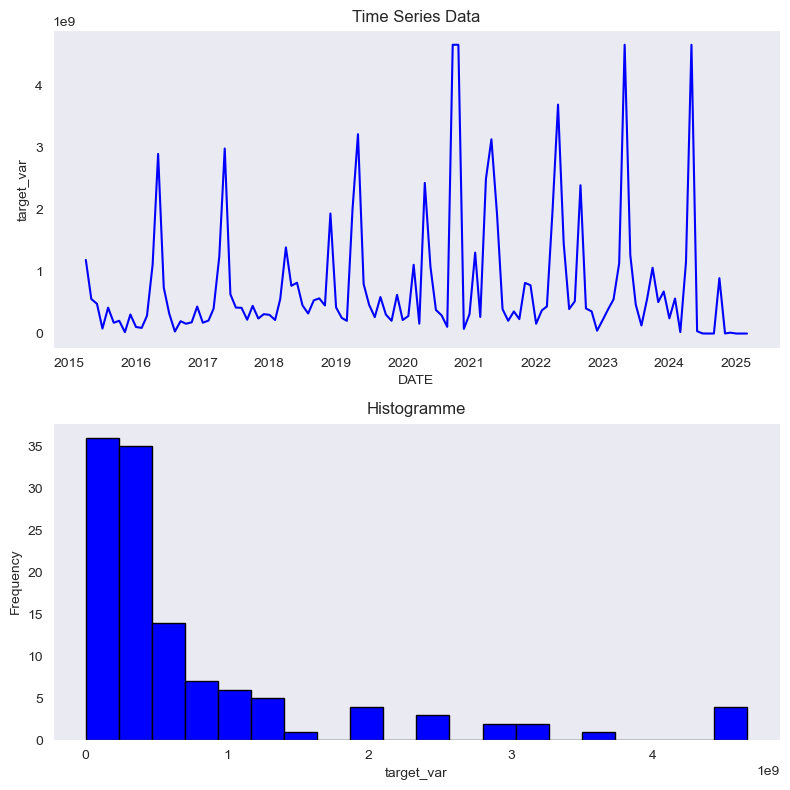

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot 1: Time Series Line Plot
axes[0].plot(df['DATE'], df['target_var'], color='blue')
axes[0].set_title('Time Series Data')
axes[0].set_xlabel('DATE')
axes[0].set_ylabel('target_var')

# Plot 2: Histogram
axes[1].hist(df['target_var'], bins=20, color='blue', edgecolor='black')
axes[1].set_title('Histogramme')
axes[1].set_xlabel('target_var')


axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


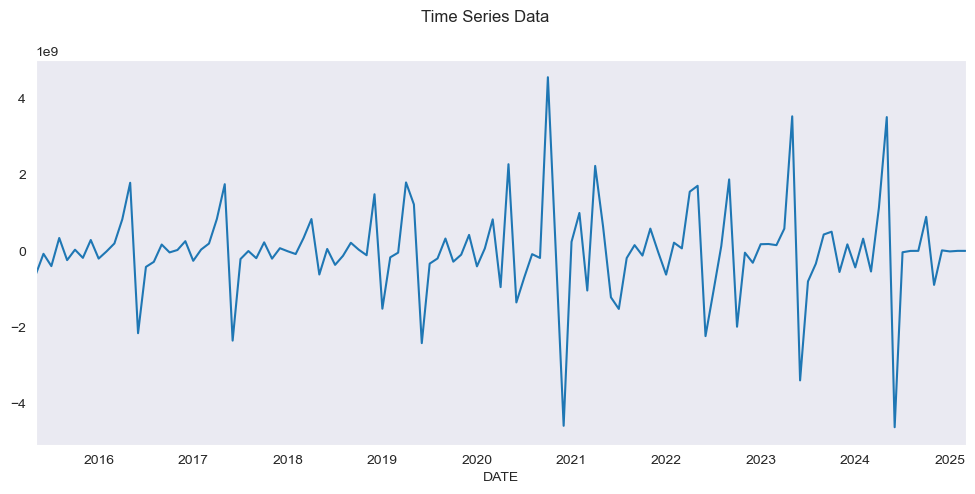

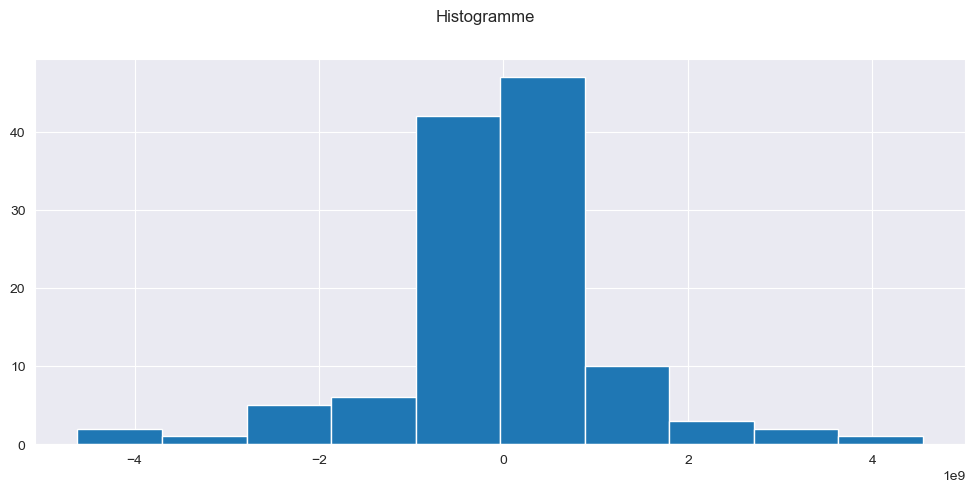

In [ ]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Time Series Data')
best_data['target_var'].plot(ax=ax)
plt.show()
#Historgram
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Histogramme')
best_data['target_var'].hist(ax=ax)
plt.show()

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols

def check_seasonality(df, m=12, alpha=0.05):
    """
    Checks for seasonality in a time series using the seasonal_decompose function from statsmodels.

    Parameters:
    df (pandas.DataFrame): The time series data.
    m (int): The seasonal period (default is 12 for monthly data).
    alpha (float): Significance level for the seasonality test (default is 0.05).

    Returns:
    dict: A dictionary containing the results of the seasonality check.
    """

    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(df['target_var'], model='additive', period=m)

    # Extract the seasonal component
    seasonal_component = decomposition.seasonal

    # Create a DataFrame with the seasonal component and an index for regression
    seasonal_df = pd.DataFrame({'seasonal': seasonal_component, 'index': range(len(seasonal_component))})
    seasonal_df = seasonal_df.dropna()  # Drop any rows with missing values

    # Fit an OLS model to test for seasonality
    model = ols('seasonal ~ index', data=seasonal_df).fit()

    # Perform ANOVA on the fitted model
    anova_table = sm.stats.anova_lm(model)
    p_value = anova_table.iloc[0, 4]  # F-test p-value

    # Determine seasonality based on p-value
    is_seasonal = p_value < alpha

    # Return the results
    results = {
        'is_seasonal': is_seasonal,
        'p_value': p_value,
        'seasonal_component': seasonal_component,
        'decomposition': decomposition
    }

    return results

In [ ]:
results=check_seasonality(df3, m=12, alpha=0.05)
results


{'is_seasonal': False,
 'p_value': 0.9787055765517967,
 'seasonal_component': DATE
 2015-05-01    1.749831e+09
 2015-06-01   -2.184983e+09
 2015-07-01   -6.033074e+08
 2015-08-01   -1.211276e+08
 2015-09-01    3.107808e+08
                   ...     
 2024-11-01   -8.412695e+07
 2024-12-01   -2.659482e+08
 2025-01-01   -3.342038e+08
 2025-02-01    1.741070e+08
 2025-03-01    1.887453e+07
 Name: seasonal, Length: 119, dtype: float64,
 'decomposition': <statsmodels.tsa.seasonal.DecomposeResult at 0x21099d18ee0>}

In [ ]:
results=check_seasonality(df2, m=12, alpha=0.05)
results


{'is_seasonal': False,
 'p_value': 0.5272700243334569,
 'seasonal_component': DATE
 2015-04-01    5.645408e+08
 2015-05-01    2.313577e+09
 2015-06-01    1.277988e+08
 2015-07-01   -4.763035e+08
 2015-08-01   -5.982261e+08
                   ...     
 2024-11-01   -3.467200e+06
 2024-12-01   -2.702104e+08
 2025-01-01   -6.052091e+08
 2025-02-01   -4.318971e+08
 2025-03-01   -4.138175e+08
 Name: seasonal, Length: 120, dtype: float64,
 'decomposition': <statsmodels.tsa.seasonal.DecomposeResult at 0x21099cf9eb0>}

In [ ]:
results=check_seasonality(best_data, m=12, alpha=0.05)
results


{'is_seasonal': False,
 'p_value': 0.9787055765517967,
 'seasonal_component': DATE
 2015-05-01    1.749831e+09
 2015-06-01   -2.184983e+09
 2015-07-01   -6.033074e+08
 2015-08-01   -1.211276e+08
 2015-09-01    3.107808e+08
                   ...     
 2024-11-01   -8.412695e+07
 2024-12-01   -2.659482e+08
 2025-01-01   -3.342038e+08
 2025-02-01    1.741070e+08
 2025-03-01    1.887453e+07
 Name: seasonal, Length: 119, dtype: float64,
 'decomposition': <statsmodels.tsa.seasonal.DecomposeResult at 0x210999cc700>}

In [ ]:
#data_transformt,best_p_value,index=get_best_transformation(data22,'AMOUNT')
best_data, best_p_value, best_index, dff, di=get_best_transformation(df2,'target_var')

Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:
shift_transformation was applied.


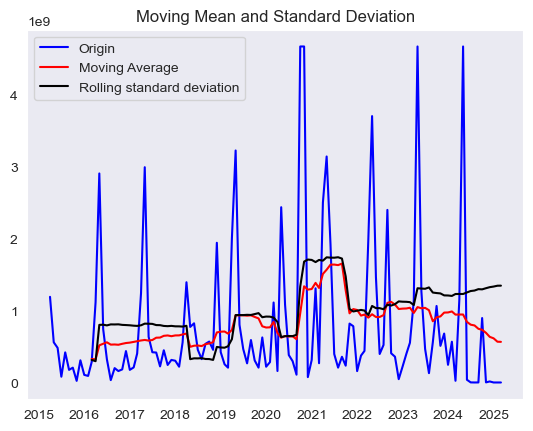

Results of Dickey-Fuller Test:
Test Statistic                  -2.238288
p-value                          0.192644
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [ ]:
def adf_Rolling_test(timeseries):

    # apply Rolling statistics

    rollingg_mean = timeseries. rolling ( window= 12 ) . mean ()
    rollingg_std=timeseries. rolling ( window= 12 ) . std ()
    plt. plot ( timeseries, color= 'blue' , label= 'Origin' )
    plt. plot ( rollingg_mean, color= 'red' , label= 'Moving Average' )
    plt. plot ( rollingg_std, color = 'black' , label = 'Rolling standard deviation' )
    plt. legend ( loc= 'best' )
    plt. title ( 'Moving Mean and Standard Deviation' )
    plt. show ()
    # apply ADF

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Call the function and run the test

adf_Rolling_test(df2['target_var'])

In [ ]:
def log_transformationm(df):

    log_data_target = pd.DataFrame(df.target_var.apply(lambda x : np.log(x)))
    return(log_data_target.dropna())
df_log=log_transformationm(df2)

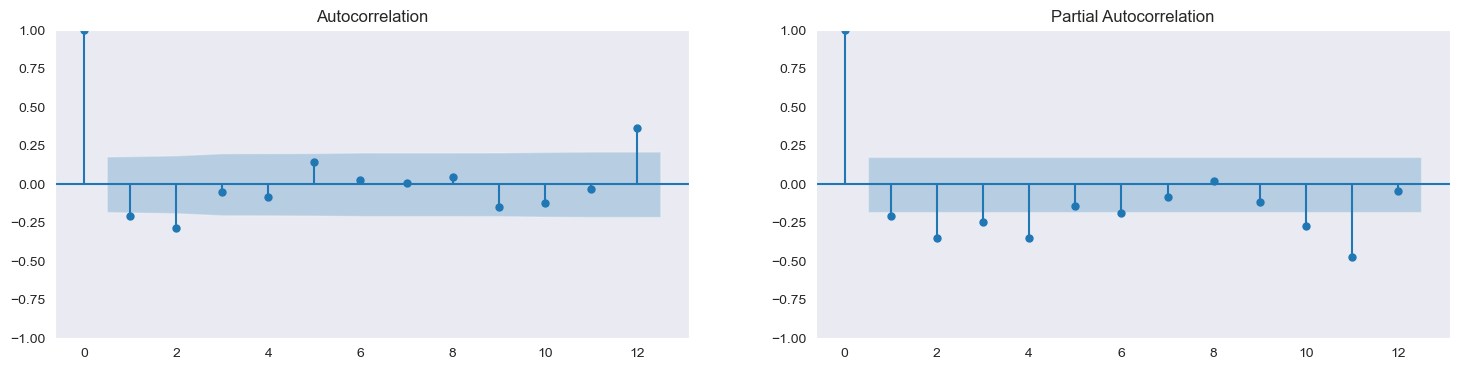

In [ ]:
#=========les corrélogrammes simple et partiel

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,4), sharex=False,sharey=False)
ax1 = plot_acf(df3['target_var'], lags=12, ax=ax1)
ax2 = plot_pacf(df3['target_var'],lags=12, ax=ax2)
plt.show()

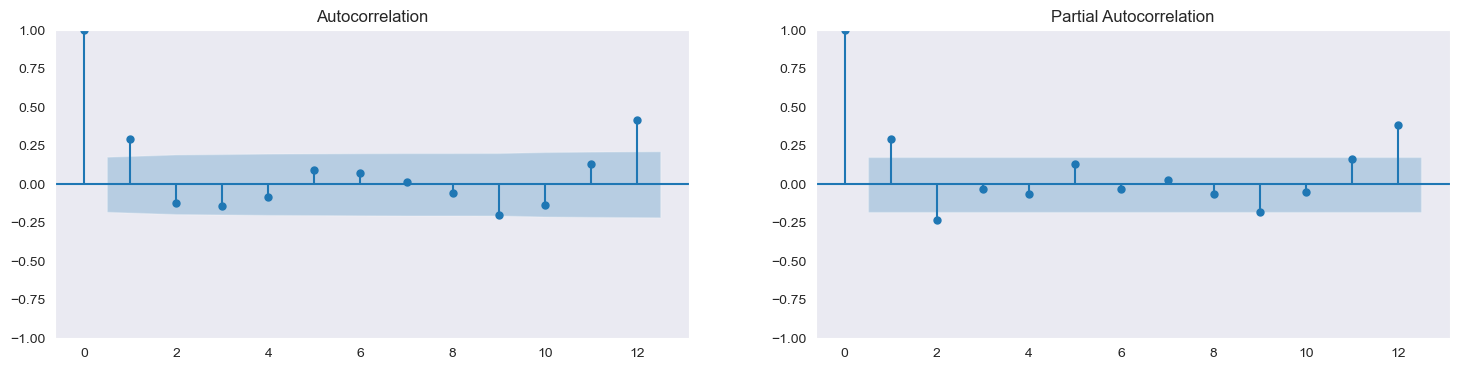

In [ ]:
#=========les corrélogrammes simple et partiel

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,4), sharex=False,sharey=False)
ax1 = plot_acf(df2['target_var'], lags=12, ax=ax1)
ax2 = plot_pacf(df2['target_var'],lags=12, ax=ax2)
plt.show()

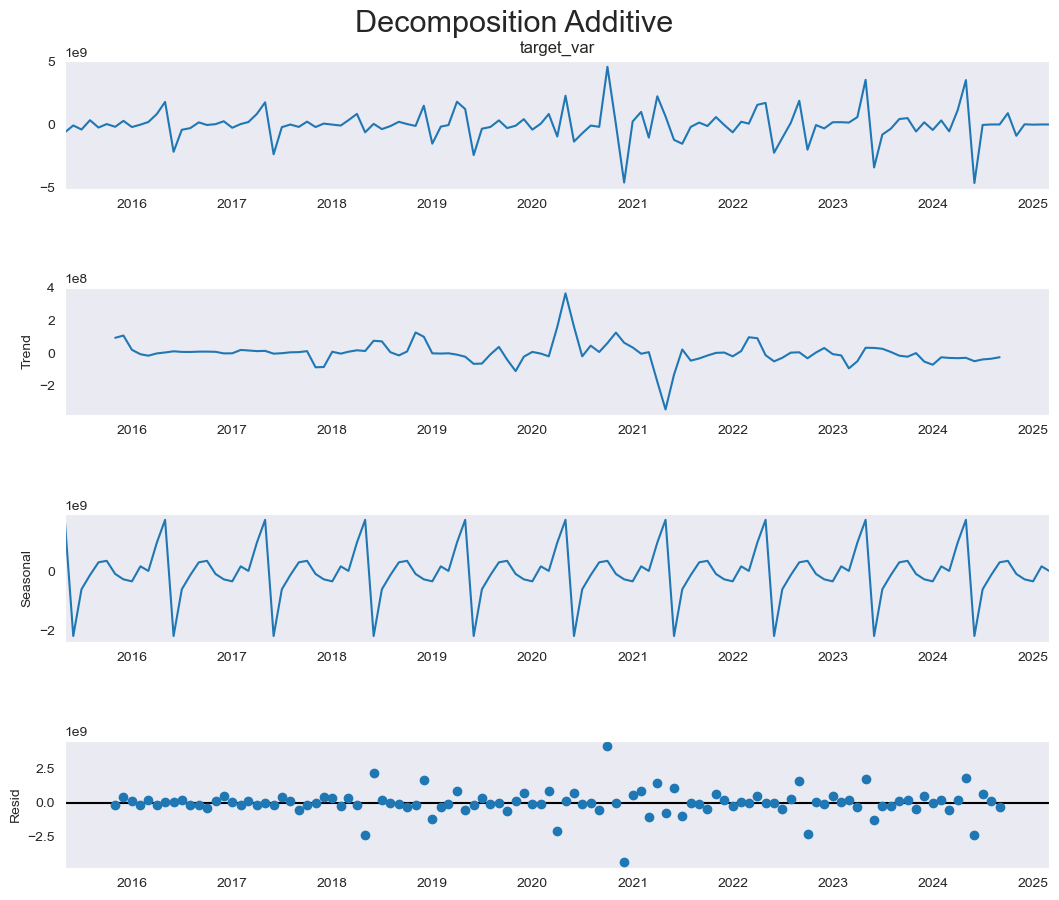

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decomp= sm.tsa.seasonal_decompose(df3['target_var'],model="additive",period=12)
ts_decomp.plot().suptitle('Decomposition Additive',fontsize=22)
fig = plt.gcf()

fig.set_size_inches(11.5, 9.5)
plt.show()


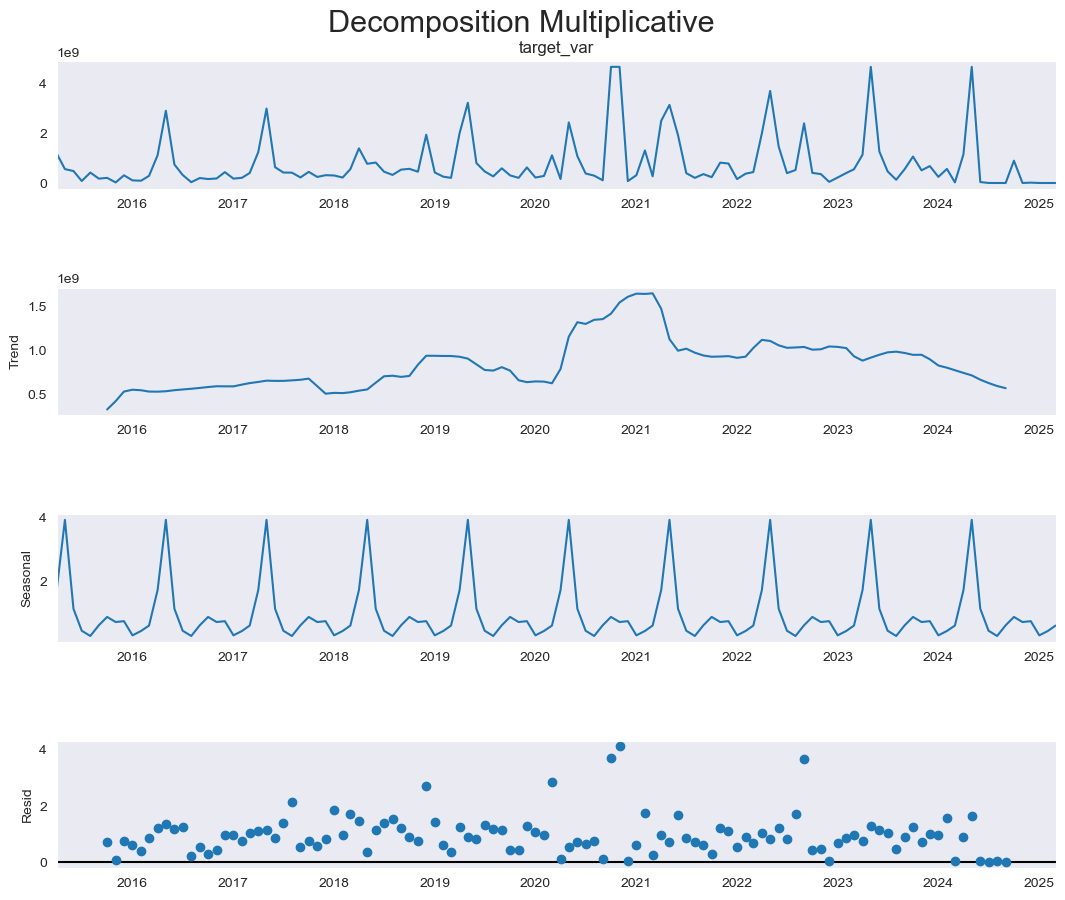

In [ ]:
result = seasonal_decompose(df2['target_var'], model='multiplicative',period=12)
result.plot().suptitle('Decomposition Multiplicative',fontsize=22)
fig = plt.gcf()

fig.set_size_inches(11.5, 9.5)
plt.show()

In [ ]:
import pmdarima as pm
model = pm.auto_arima(df2['target_var'], d=0, D=1,
                      m=12, trend='c', seasonal=True,
                      start_p=0, start_q=0, max_order=6, test='adf',

                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=4773.987, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4803.329, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4780.626, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4767.073, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4803.329, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=4798.007, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=4768.971, Time=0.20 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=4768.888, Time=0.45 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=4779.429, Time=0.14 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=4770.693, Time=0.91 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=4772.181, Time=0.15 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=4768.476, Time=0.31 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=4769.903, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=4768.020, Time=0.25 sec
 ARIMA(1,0,2)(0,1,1

In [ ]:
def split_function(data,exogVar,data_target,start_train,end_train):
    X=data[exogVar]
    Y=data[data_target]
    X_train=X[start_train:end_train]
    X_test=X[end_train:]
    y_train=Y[start_train:end_train]
    y_test =Y[end_train:]

    return(X_train, X_test, y_train, y_test,X,Y)
X_train, X_test, y_train, y_test,X,Y=split_function(df2,'exogVar','target_var','2015-04-01','2023-04-01')

In [ ]:
df3['exogVar']=df2['exogVar']

In [ ]:
X_traina, X_testa, y_traina, y_testa,Xa,Ya=split_function(df3,'exogVar','target_var','2015-04-01','2023-04-01')

                            AutoReg Model Results                             
Dep. Variable:             target_var   No. Observations:                   96
Model:              Seas. AutoReg(12)   Log Likelihood               -1832.272
Method:               Conditional MLE   S.D. of innovations      719328693.080
Date:                Thu, 17 Apr 2025   AIC                           3714.545
Time:                        09:52:33   BIC                           3775.315
Sample:                    05-01-2016   HQIC                          3738.974
                         - 04-01-2023                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.841e+09   3.56e+08      5.172      0.000    1.14e+09    2.54e+09
s(2,12)        -2.486e+09   4.79e+08     -5.188      0.000   -3.42e+09   -1.55e+09
s(3,12)         -2.16e+09   5.44e+08

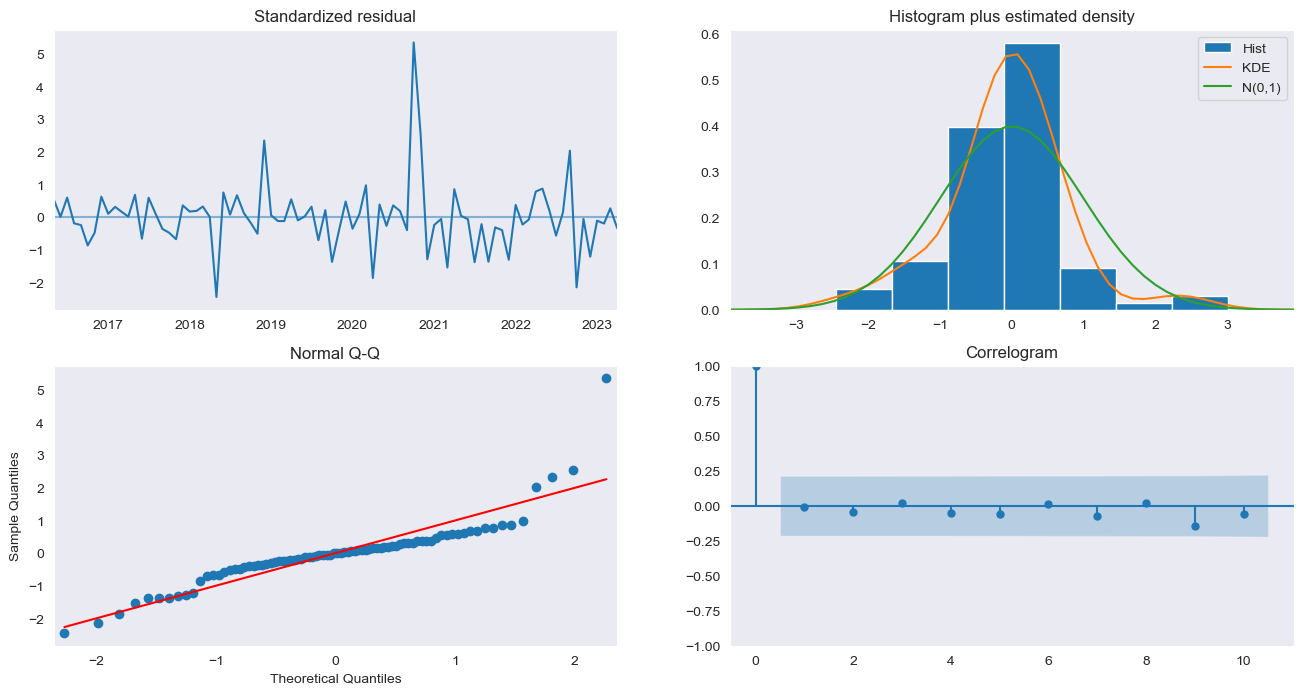

In [ ]:
########### AR #########
def train_AR(y_train,lag):
    ar_model = AutoReg(y_train, lags=lag, trend='c', seasonal=True ,period=12)
    modelAR_fit=ar_model.fit()#  #tuning lag values == 12 , 24, 36 -> best  Log Likelihood, mse ,...
    model='AR Model'
    #print(ar_model.summary())
    return(modelAR_fit,model) # return trained model
#===============
modelAR_fit,modelar=train_AR(y_traina,12)
print(modelAR_fit.summary())
modelAR_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:             target_var   No. Observations:                   97
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2125.343
Date:                Thu, 17 Apr 2025   AIC                           4254.686
Time:                        10:40:03   BIC                           4259.815
Sample:                    04-01-2015   HQIC                          4256.759
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9457      0.043    -22.017      0.000      -1.030      -0.861
sigma2      1.205e+18   7.93e-21   1.52e+38      0.000     1.2e+18     1.2e+18
Ljung-Box (L1) (Q):                   9.63   Jarque-

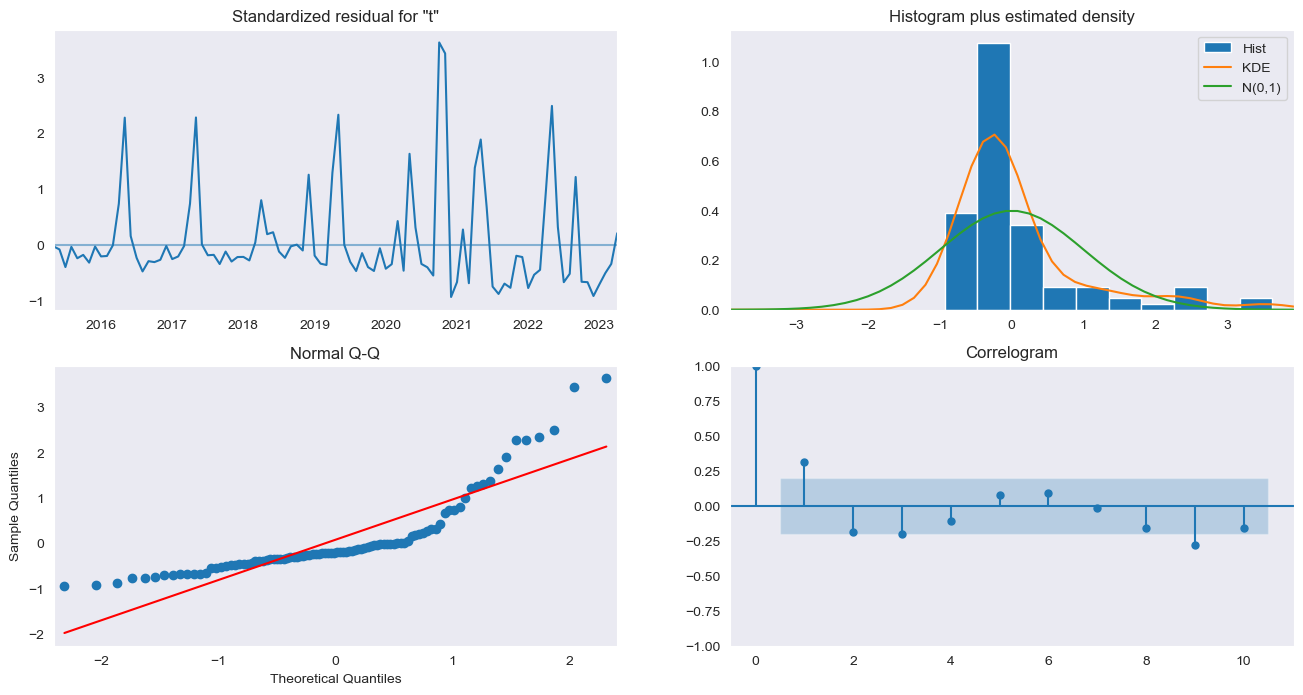

In [ ]:
######### ARIMA ######################

def train_ARIMA(y_train,d):
    arima_model = ARIMA(y_train, order=(0,d,1)) #
    modelAri_fit=arima_model.fit()
    model='ARIMA'
    return(modelAri_fit,model) # return trained model
#========================
modelARi_fit,modelari=train_ARIMA(y_train,1)
print(modelARi_fit.summary())
modelARi_fit.plot_diagnostics(figsize=(16, 8))
plt.show()


In [ ]:
#========= Function to optimize parameters of SARIMA =============#

def optimize_SARIMA(parameters_list,y_train,X_train):

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(y_train,exog=X_train, order=(param[0],1, param[1]),seasonal_order=(param[2],1, param[3],12),enforce_stationary=False,enforce_invertibility=False,freq="MS").fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df
###########
p = range(0, 3, 1)
q = range(0, 3, 1)
P = range(0, 2, 1)
Q = range(0, 2, 1)

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
result_df = optimize_SARIMA(parameters_list,y_train,X_train)
result_df

  0%|          | 0/36 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",3731.415733
1,"(2, 1, 0, 1)",3732.091643
2,"(1, 2, 0, 1)",3732.508108
3,"(0, 2, 1, 1)",3732.658243
4,"(2, 1, 1, 1)",3733.158346
5,"(1, 2, 1, 1)",3733.646995
6,"(2, 2, 0, 1)",3734.409361
7,"(1, 1, 0, 1)",3735.085106
8,"(2, 2, 1, 1)",3735.516776
9,"(1, 1, 1, 1)",3736.444925


                                      SARIMAX Results                                       
Dep. Variable:                           target_var   No. Observations:                   97
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1859.736
Date:                              Thu, 17 Apr 2025   AIC                           3727.472
Time:                                      09:52:56   BIC                           3737.195
Sample:                                  04-01-2015   HQIC                          3731.381
                                       - 04-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6094      0.137     -4.457      0.000      -0.877      -0.341
ma.L2         -0.31

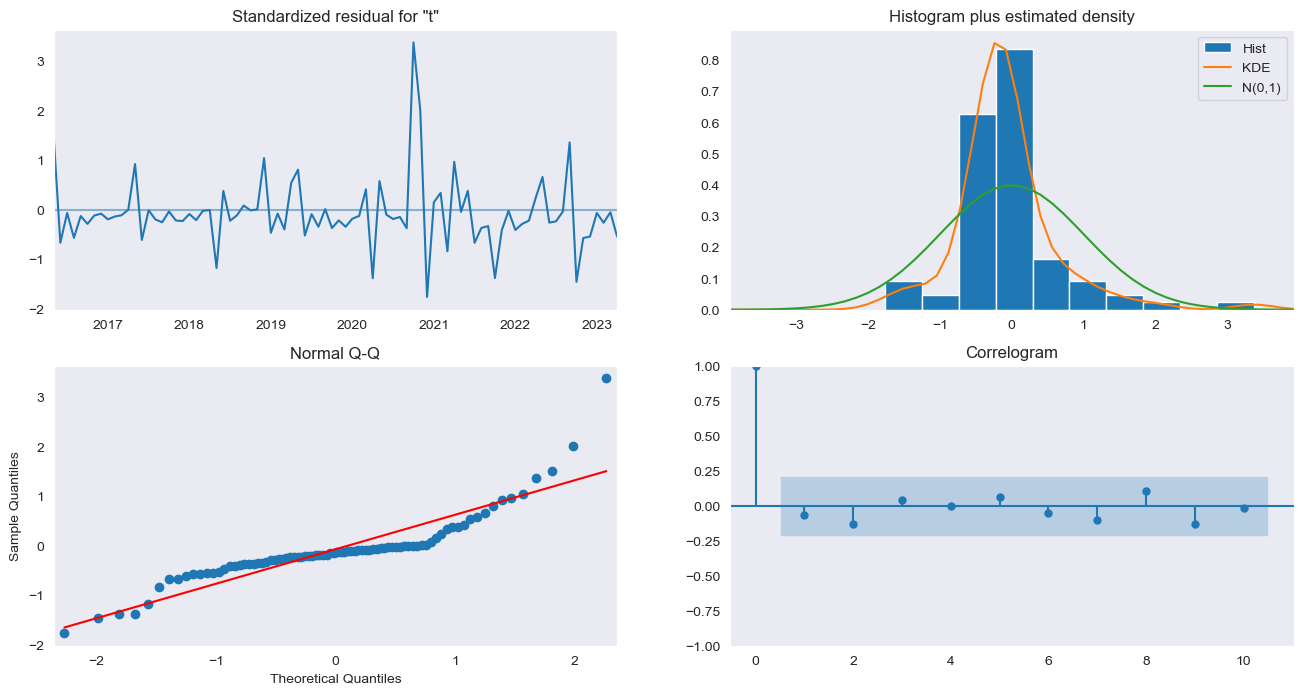

In [ ]:
########### SARIMA ###############

def train_SARIMA(y_train,d):
    ## get best parametrs
    #listt=resulta_Optimization(3,3,2,2,d,12,d,df)

    Sarima_model = SARIMAX(y_train,order=(0,d,2),
                            seasonal_order=(0,d,1,12),enforce_stationary=False,enforce_invertibility=False,freq="MS")
    # get fitted_model


    modelSA_fit=Sarima_model.fit()
    model='SARIMA'
    return(modelSA_fit,model)
#==========================
modelSARi_fit,modelSari=train_SARIMA(y_train,1)
print(modelSARi_fit.summary())
modelSARi_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                           target_var   No. Observations:                   97
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1860.708
Date:                              Thu, 17 Apr 2025   AIC                           3731.416
Time:                                      09:53:01   BIC                           3743.570
Sample:                                  04-01-2015   HQIC                          3736.302
                                       - 04-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exogVar     7.148e+08   1.11e-11   6.43e+19      0.000    7.15e+08    7.15e+08
ma.L1         -0.53

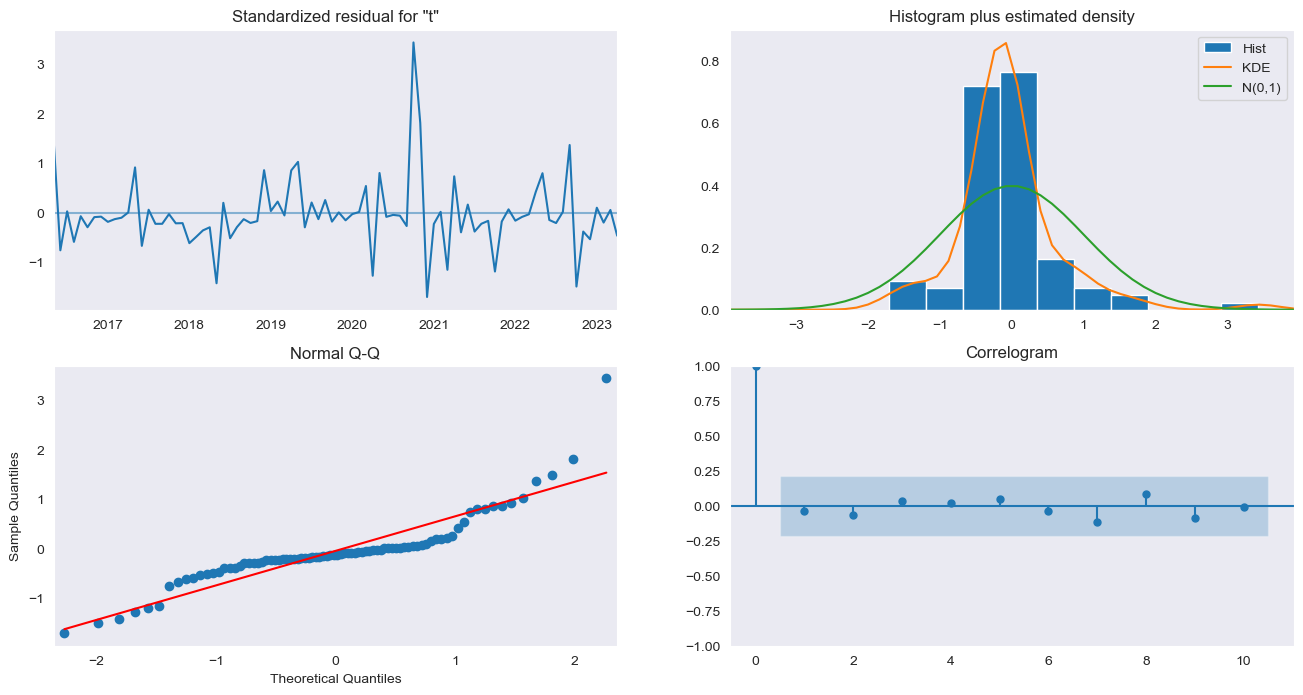

In [ ]:
########### SARIMAXX ###############

def train_SARIMAXX(y_train,X_train,d):
    ## get best parametrs
    #listt=resulta_Optimization(3,3,2,2,d,12,d,df)

    Sarimax_model = SARIMAX(y_train,exog=X_train,order=(0,d,2),
                            seasonal_order=(0,d,1,12),enforce_stationary=False,enforce_invertibility=False,freq="MS")
    # get fitted_model

    modelSAx_fit=Sarimax_model.fit()
    model='SARIMAX'
    return(modelSAx_fit,model)
#========================
modelSARix_fit,modelSarix=train_SARIMAXX(y_train,X_train,1)
print(modelSARix_fit.summary())
modelSARix_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Define your evaluation function
def evalution_measures(test_set, pred):
    mse = mean_squared_error(test_set, pred)
    rmse = math.sqrt(mse)  # the average deviation between the predicted points scored and the actual points scored
    mae = mean_absolute_error(test_set, pred)
    mape = mean_absolute_percentage_error(test_set, pred)
    r2 = r2_score(test_set, pred)
    return mse, rmse, mae, mape, r2

# Assuming you have these variables from your predictions
pred_testar = modelAR_fit.predict(len(y_train), (len(y_train) + len(y_test) - 1), dynamic=False)
pred_testsarix = modelSARix_fit.predict(len(y_train), (len(y_train) + len(y_test) - 1), exog=X_test, dynamic=False)
pred_testsari = modelSARi_fit.predict(len(y_train), (len(y_train) + len(y_test) - 1), dynamic=False)
pred_testari = modelARi_fit.predict(len(y_train), (len(y_train) + len(y_test) - 1), dynamic=False)

# Initialize a list to store results
results = []

# Evaluation for AR model
ar = evalution_measures(y_test, pred_testar)
results.append(['AR', *ar])

# Evaluation for ARi model
arim = evalution_measures(y_test, pred_testari)
results.append(['ARi', *arim])

# Evaluation for SARi model
sar = evalution_measures(y_test, pred_testsari)
results.append(['SARi', *sar])

# Evaluation for SARix model
sarx = evalution_measures(y_test, pred_testsarix)
results.append(['SARix', *sarx])

# Create DataFrame with the results
df_results = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2'])

# Display the DataFrame
#print(df_results)
df_results

,Model,MSE,RMSE,MAE,MAPE,R2
0,AR,3.538682e+18,1.881139e+09,1.220361e+09,24.087217,-1.260188
1,ARi,1.579118e+18,1.256630e+09,8.555271e+08,41.240274,-0.008597
2,SARi,1.690752e+18,1.300289e+09,9.903398e+08,46.741646,-0.079898
3,SARix,1.697918e+18,1.303042e+09,9.782945e+08,45.842109,-0.084475


In [ ]:
df_results.drop(columns=['R2'])

,Model,MSE,RMSE,MAE,MAPE
0,AR,3.538682e+18,1.881139e+09,1.220361e+09,24.087217
1,ARi,1.579118e+18,1.256630e+09,8.555271e+08,41.240274
2,SARi,1.690752e+18,1.300289e+09,9.903398e+08,46.741646
3,SARix,1.697918e+18,1.303042e+09,9.782945e+08,45.842109


Text(0.5, 1.0, 'Comparaison entre les modéles par mape')

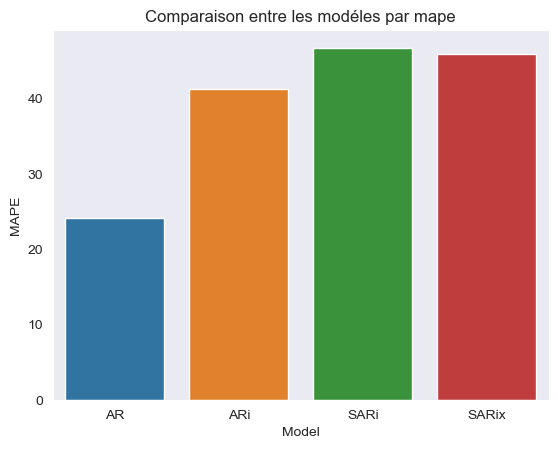

In [ ]:
ax = sns.barplot(x="Model", y="MAPE", data=df_results)
ax.set_title("Comparaison entre les modéles par mape")

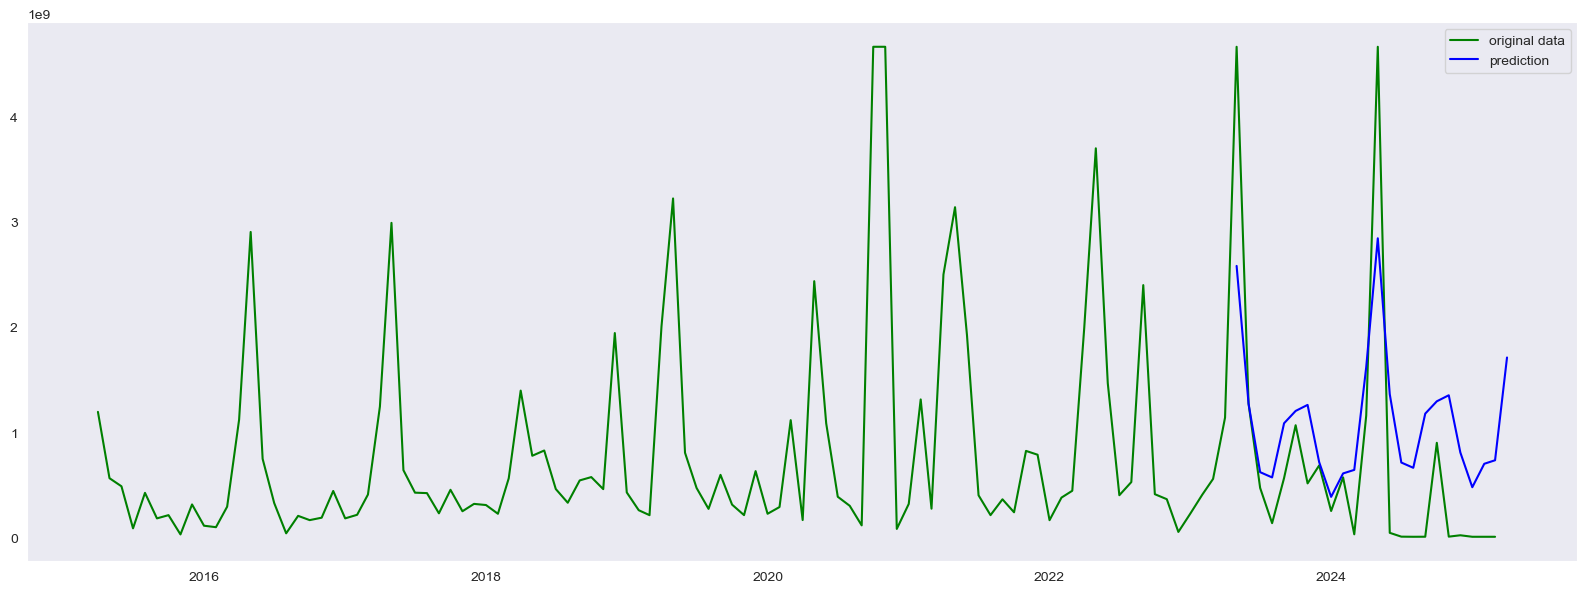

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df2['target_var'], color='green',label='original data')

plt.plot(pred_testsarix,color='blue',label='prediction')
plt.legend()